참고로 selnium은 페이지가 다 로딩 된 후에, 가져옴. 때문에, 속도가 느릴 수 밖에 없다.

### Selenium을 이용한 이미지 크롤링
- 유투브 영상을 이미지로 크롤링
- 특정 영역(Element)을 자르기
     - pillow : python을 이용해서 이미지를 전처리해주는 대표적인 패키지
     - conda install -c anaconda pillow
     - pip install pillow
- 유투브 영상 데이터를 다운로드
- fake_useragent 사용법
- headless 설정
    - 브라우져를 화면에 띄우지 않고 RAM영역에만 띄어서 사용하는 방법
    - 서버에서 selenium을 이용해서 크롤링할때 사용
    - 예전에는 PhantomJS 등을 많이 썼는데, 요즘은 안쓴다. headless chrome을 쓴다.

In [1]:
import requests
import time
import pandas as pd
from selenium import webdriver
from PIL import Image as pil

#### 1. 이미지 스크린샷

In [1]:
!mkdir datas

In [6]:
# 혹시 영상이 private 이나 삭제되었다면, 다른 공개된 영상 주소를 복사, 붙여넣기 해주세요.
# query t=100s : 100초로 이동
url = "https://www.youtube.com/watch?v=cnXapYkboRQ&t=100s"
driver = webdriver.Chrome(executable_path="/usr/local/bin/chromedriver")
driver.get(url)

In [7]:
# 영상 가운데 큰 재생버튼을 눌러주는 코드 입니다.
try:
    driver.find_element_by_css_selector(".ytp-large-play-button.ytp-button").click()
except:
    pass # 만약 재생버튼이 없다면 무시합니다.

In [8]:
driver.save_screenshot("datas/screenshot.png")
driver.quit()

In [6]:
!ls datas

screenshot.png


(2400, 1716)


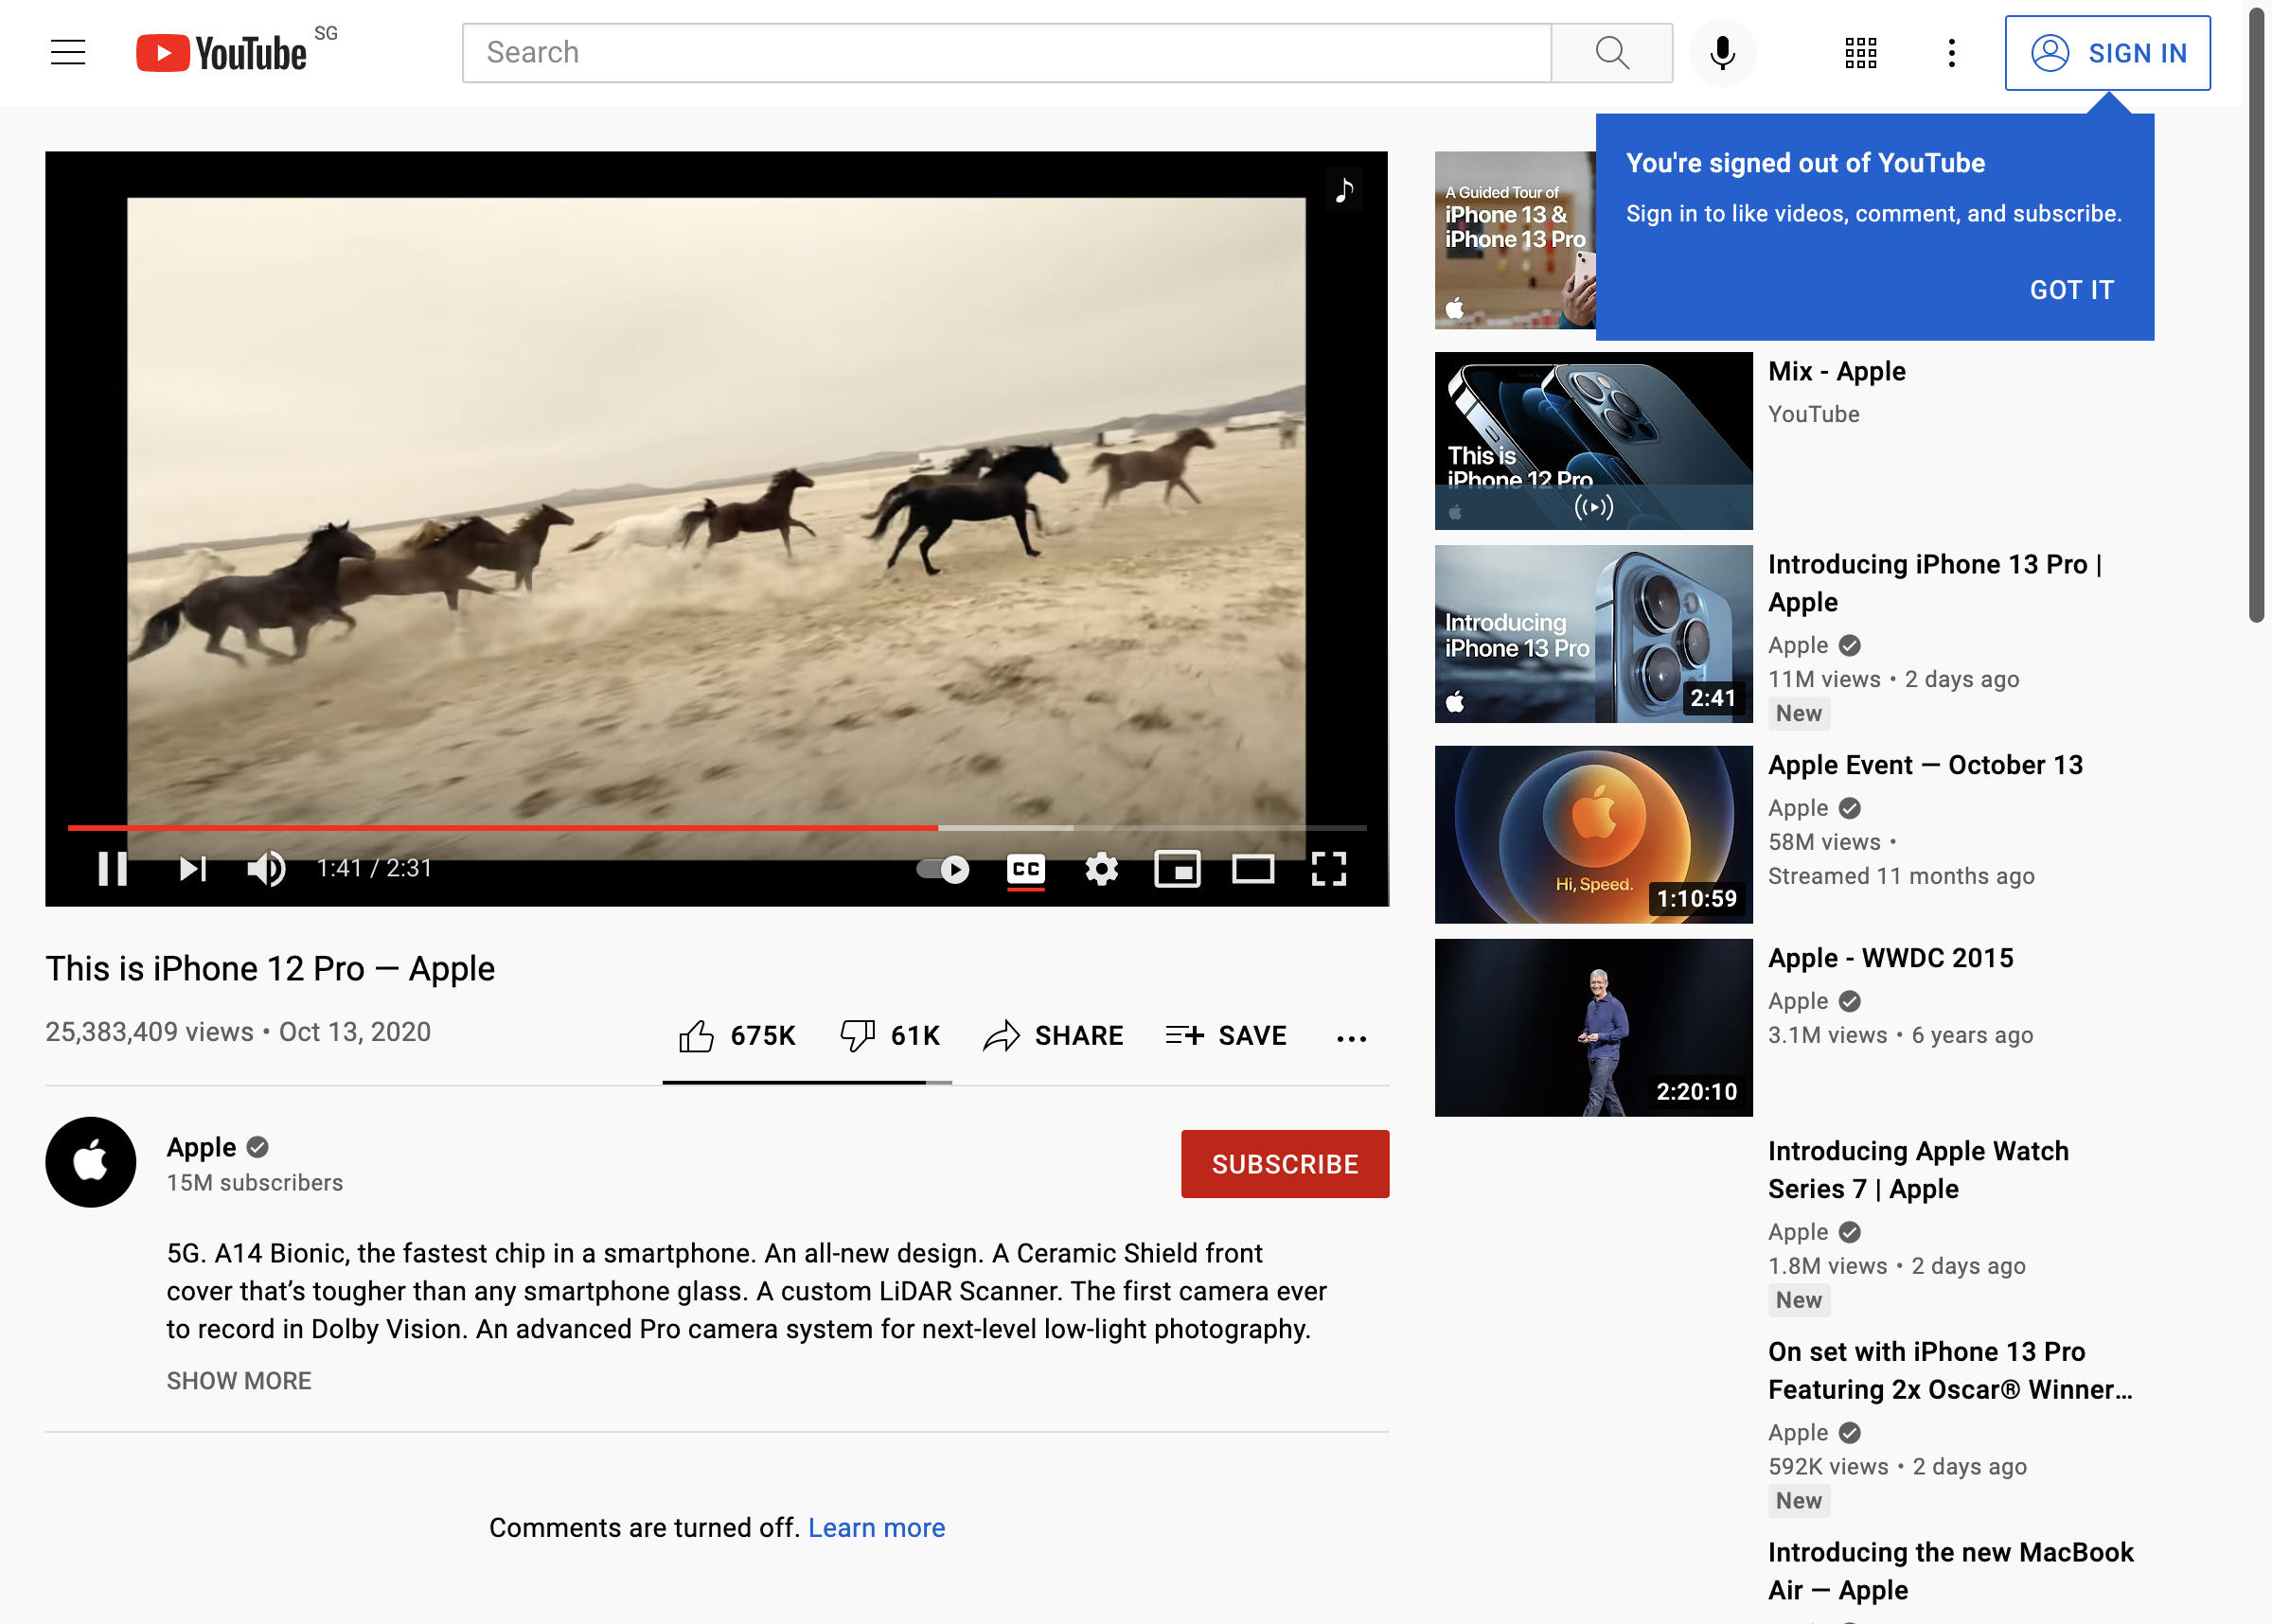

In [9]:
pil_img = pil.open("datas/screenshot.png")
print(pil_img.size)
pil_img

#### 2. 특정 영역의 엘리먼트 좌표값 구하기

In [21]:
driver = webdriver.Chrome(executable_path="/usr/local/bin/chromedriver")
driver.get(url)

In [15]:
# element = driver.find_element_by_css_selector("#movie_player")
element = driver.find_element_by_css_selector("#ytd-player")
# coordinate of top left point of this element
location = element.location
size = element.size
print(location, size)
driver.quit()

{'x': 24, 'y': 80} {'height': 399, 'width': 710}


In [25]:
# area 변경 : 해상도에 따라서 비율이 달라지기 때문에 비율을 맞춰 줘야 합니다.
left = location["x"] * 2
top = location["y"]* 2
right = left + size["width"]* 2
bottom = top + size["height"]* 2
area = (left, top, right, bottom)
area

(48, 160, 1468, 958)

#### 3. 이미지를 pillow로 잘라주기

In [26]:
pil_element_img = pil_img.crop(area)
pil_element_img.size

(1420, 798)

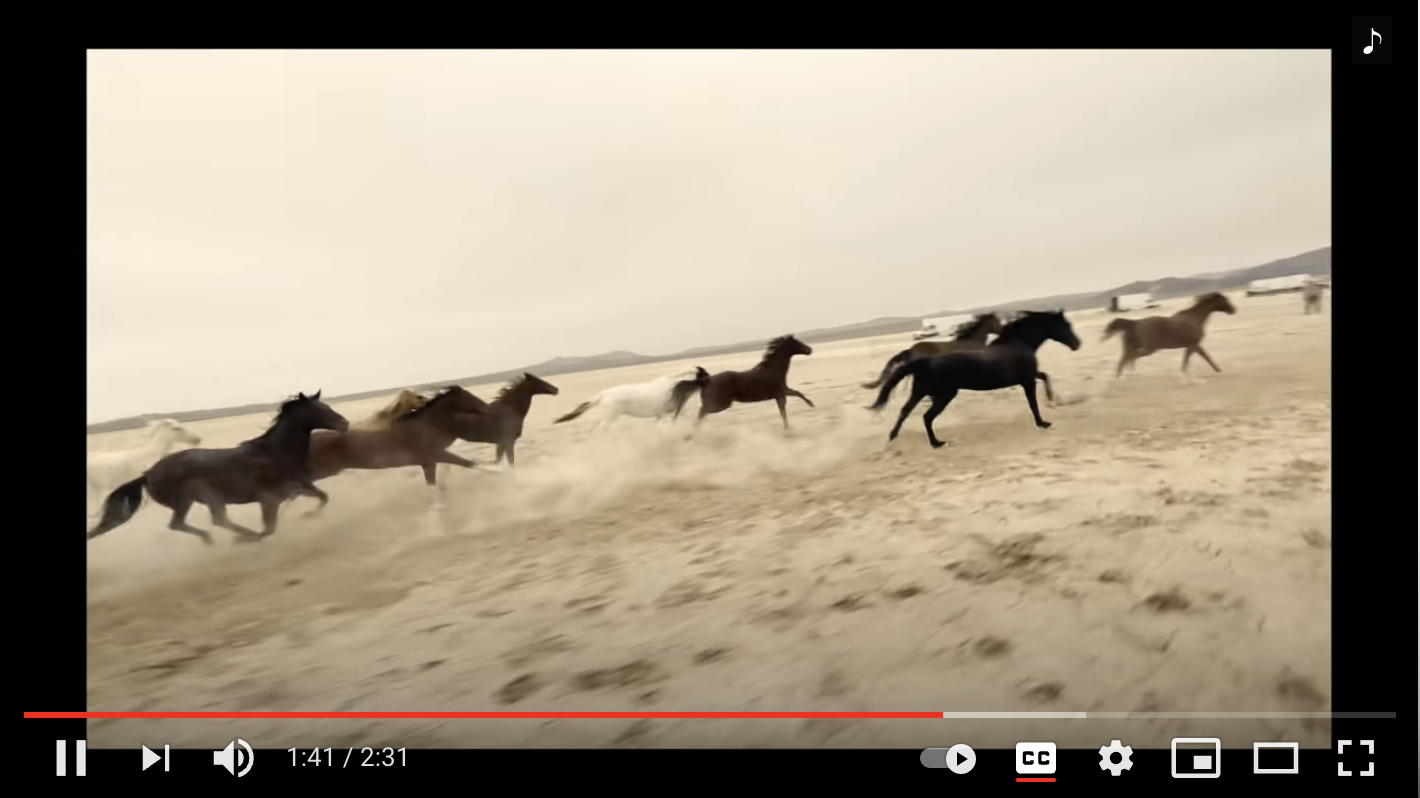

In [27]:
pil_element_img = pil_img.crop(area)
pil_element_img

In [28]:
# 이미지 저장
pil_element_img.save("datas/screenshot_element.png")

In [29]:
!ls datas

screenshot.png         screenshot_element.png


#### 썸네일 만들기 
- 원본 이미지를 다양한 사이즈로 축소하는 방법

In [30]:
pil_element_img.size

(1420, 798)

(285, 160)


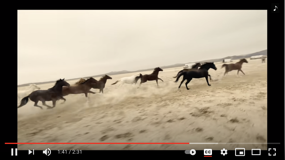

In [31]:
pil_element_img.thumbnail((320, 160))
print(pil_element_img.size)
pil_element_img

#### fake useragent

In [32]:
from fake_useragent import UserAgent

In [33]:
# 크롬 드라이버의 Agent 확인
# 실행할 때 마다, 같은 Agent를 갖는다.

driver = webdriver.Chrome(executable_path="/usr/local/bin/chromedriver")
agent = driver.execute_script("return navigator.userAgent;")
driver.quit()
print(agent)

Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36


그러나, User Agent를 다르게 써야 할 때가 있다.

In [34]:
UserAgent().chrome

'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36'

In [36]:
# user agent 설정
options = webdriver.ChromeOptions()
options.add_argument("user-agent={}".format(UserAgent().chrome))
driver = webdriver.Chrome(executable_path="/usr/local/bin/chromedriver", options=options)
agent = driver.execute_script("return navigator.userAgent;")
driver.quit()
print(agent)

Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36


#### Headless
- 브라우져를 화면에 띄우지 않고 메모리상에서만 실행하는 방법
- 크롬 버전 60 이상에서만 사용이 가능
- window 화면이 지원되지 않는 환경에서 사용

In [39]:
options = webdriver.ChromeOptions()
options.add_argument("headless")
driver = webdriver.Chrome(executable_path="/usr/local/bin/chromedriver", options=options)
driver.get("https://naver.com")
print(driver.title)
driver.quit()

NAVER


#### 영상 파일 다운로드
- www. -> ss 로 변경하면 다운 로드 받을수 있는 사이트에 접속

In [40]:
def download(title, link):
    response = requests.get(link, stream=True)
    save_path, size = "datas/{}".format(title), 0
    with open(save_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                size += 1024
                f.write(chunk)
    return size

In [41]:
url = "https://www.youtube.com/watch?v=sARHNQHUha8"

https://www.youtube.com/watch?v=sARHNQHUha8

아래 링크 주소는 '낮은 품질로' 를 클릭하면 다운로드 버튼을 확인할 수 있습니다.

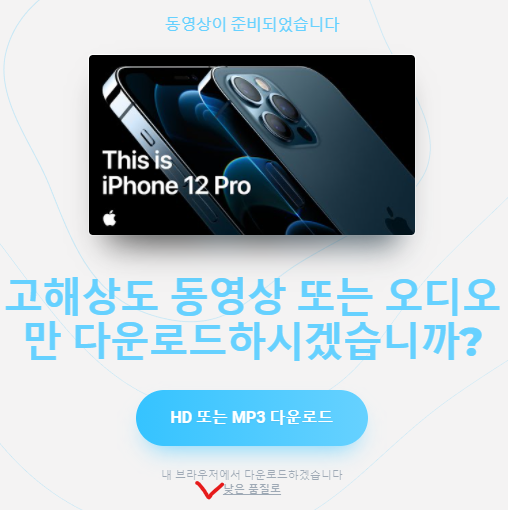


In [42]:
link = "https://r1---sn-a5mlrn7s.googlevideo.com/videoplayback?expire=1631923914&ei=atpEYcbRJ7-nir4P6NuXgAQ&ip=64.145.93.203&id=o-AOLMhQQuk1aRO2jG-Zb-l4YxhrWUJCG7m8Ku6DKxDWqi&itag=22&source=youtube&requiressl=yes&mh=Y1&mm=31%2C29&mn=sn-a5mlrn7s%2Csn-a5meknsy&ms=au%2Crdu&mv=m&mvi=1&pl=24&initcwndbps=630000&vprv=1&mime=video%2Fmp4&ns=X65vPtF_iG2AAnlpXeI8fpUG&cnr=14&ratebypass=yes&dur=60.116&lmt=1575632603821062&mt=1631901888&fvip=1&fexp=24001373%2C24007246&beids=9466585&c=WEB&txp=6316222&n=BlZdIMi-KiWKFD&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Ccnr%2Cratebypass%2Cdur%2Clmt&sig=AOq0QJ8wRQIhANNgvmlHnYuCIAHq7HTQgXPNct4banQ5Nhlgt5mRVsviAiA2N-btxUU6aju2dVIqwSPgKbmSKh3GonGZCKT3FNJe0g%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AG3C_xAwRgIhALAk_tlkaX7ADW2TsAD-MMKqN3AAu2zHlPXOfTDhL039AiEAgl6KHvCZSJsMnyfFyXXW6SUUfU1_zHndBDcMtY3hI58%3D&title=%EC%84%B8%EC%83%81%20%EB%AA%A8%EB%93%A0%20%EA%B0%80%EB%8A%A5%EC%84%B1%EC%9D%B4%20%ED%94%8C%EB%A0%88%EC%9D%B4%EB%90%98%EA%B8%B0%EB%A5%BC%20%7C%20Google%20Play%20%EC%B0%BD%EA%B5%AC%20%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8%20%7C%20%EC%A4%91%EC%86%8C%EB%B2%A4%EC%B2%98%EA%B8%B0%EC%97%85%EB%B6%80%20x%20%EA%B5%AC%EA%B8%80%ED%94%8C%EB%A0%88%EC%9D%B4"

In [43]:
title = "google_play.mp4"
size = download(title, link)
print("{} Mb".format(round(size/1024/1024,2)))

11.74 Mb
